# A simple VAE


## Library imports
The following code contains the required libraries for the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid


#import torchbearer
#import torchbearer.callbacks as callbacks
#from torchbearer import Trial, state_key
#MU = state_key('mu')
#LOGVAR = state_key('logvar')

#import ...


## MNIST

In [2]:
#MNIST Settings
#classes = [0, 1, 4, 9]
batch_size = 64
eval_batch_size = 64

In [3]:
#MNIST Import
#source 7.1 autoencoder lab
from torchvision.datasets import MNIST

# transforms into tensor, can be extend
transformations = transforms.Compose([transforms.ToTensor()]) 


# Define the train and test sets
train_data = MNIST("./", train=True,  transform=transformations, download=True)
test_data  = MNIST("./", train=False, transform=transformations)


#def stratified_sampler(labels):
#    """Sampler that only picks datapoints corresponding to the specified classes"""
#    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#    indices = torch.from_numpy(indices)
#    return SubsetRandomSampler(indices)

#load the datasets into DataLoader classes, sampler removed!
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=eval_batch_size)


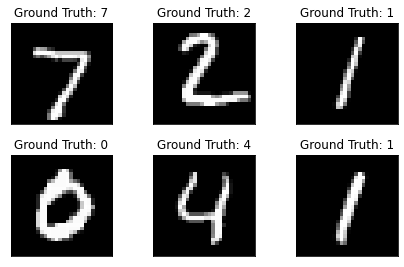

In [4]:
# https://nextjournal.com/gkoehler/pytorch-mnist
# Print from testset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## Fashion MNIST

In [81]:
from torchvision.datasets import FashionMNIST

# transforms into tensor, can be extend
transformations = transforms.Compose([transforms.ToTensor()]) 


# Define the train and test sets
train_data = FashionMNIST("./", train=True,  transform=transformations, download=True)
test_data  = FashionMNIST("./", train=False, transform=transformations)


#def stratified_sampler(labels):
#    """Sampler that only picks datapoints corresponding to the specified classes"""
#    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#    indices = torch.from_numpy(indices)
#    return SubsetRandomSampler(indices)

#load the datasets into DataLoader classes, sampler removed!
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=eval_batch_size)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/home/benjamin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


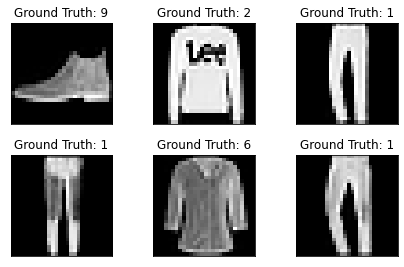

In [82]:
# https://nextjournal.com/gkoehler/pytorch-mnist
# Print from testset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## The Model 

inspired by: https://www.kaggle.com/ethanwharris/fashion-mnist-vae-with-pytorch-and-torchbearer

In [83]:
#https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [84]:
#Settings
latent_size = 15
learning_rate = 1e-3
num_epochs = 5

In [85]:
conv1 = (1, 32, 4, 1, 2)
conv2 = (conv1[1], 32, 4, 2, 1)
conv3 = (conv2[1], 64, 4, 2, 1)


##Look at 7.2 to see how to make encoder and decoder take non-fixed size image. 

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoEncoder,self).__init__()
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1[0],out_channels=conv1[1],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv2[0],out_channels=conv2[1],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv3[0],out_channels=conv3[1],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv3[1],out_channels=conv3[0],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv2[1],out_channels=conv2[0],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4],output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv1[1],out_channels=conv1[0],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            )
        
        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)
        self.upsample = nn.Linear(latent_size, 64 * 7 * 7)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

        
    # https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/    
    def forward(self, x):
        # encoding
        
        x = self.encoder(x)
        x = x.view(-1,64*7*7)
        mu = self.mu(x)
        log_var = self.logvar(x)
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # decoding
        z = self.upsample(z)
        #print(z.shape)
        z = z.view(-1,64,7,7)
        
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction, mu, log_var
        
     
print(VariationalAutoEncoder(latent_size=latent_size))

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (mu): Linear(in_features=3136, out_features=15, bias=True)
  (logvar): Linear(in_features=3136, out_features=15, bias=True)
  (upsample): Linear(in_features=15, out_features=3136, bias=True)
)


### KL

### Visualisation

### Training

In [86]:
vae = VariationalAutoEncoder(latent_size=latent_size)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')




In [87]:
def fit_vae(vae, train_loader):
    vae.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for x, y in train_loader:
        # x.view?
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae(x)
        bce_loss = criterion(reconstruction, x)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(train_loader.dataset)
    return train_loss

def test_vae(vae, test_loader):
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # x.view?
            x = x.to(device)
            reconstruction, mu, logvar = vae(x)
            bce_loss = criterion(reconstruction, x)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(test_loader.dataset)
    return val_loss
            

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
vae = vae.to(device)

##
train_loss = []
test_loss = []

for current_epoch in range(num_epochs):
    print(f"Epoch {current_epoch+1} of {num_epochs}")
    train_epoch_loss = fit_vae(vae, train_loader)
    test_epoch_loss = test_vae(vae, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")
    

>> Using device: cuda:0
Epoch 1 of 5
Train Loss: 263.3038
Val Loss: 250.6375
Epoch 2 of 5
Train Loss: 246.2054
Val Loss: 247.6730
Epoch 3 of 5
Train Loss: 243.8155
Val Loss: 246.1628
Epoch 4 of 5
Train Loss: 242.5548
Val Loss: 243.8178
Epoch 5 of 5
Train Loss: 241.6757
Val Loss: 243.5338


<ipython-input-102-7dad42aae1e3>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


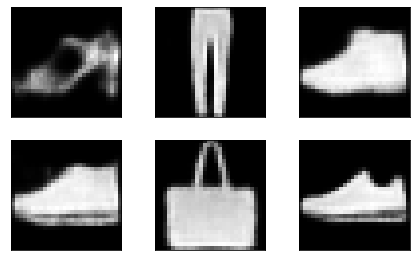

In [102]:
# examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output,_,_ = vae(example_data.to(device))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(output.cpu()[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig.show()